# Timeseries Clustering

In [60]:
### load packages ###
import os
import math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [34]:
### Import Data and preprocess dataframe ###
url = "https://raw.githubusercontent.com/AnjaDeric/MDA-TeamCroatia/main/active_cases.csv"
df_active = pd.read_csv(url, dtype={"fips": str})
df_active = df_active.reset_index()
df_active = df_active.set_index('fips')
df_active = df_active.drop({'index','county','state', 'lat', 'long', 'population'}, axis = 1)
df_active = df_active.T
df_active = df_active.reset_index()
df_active['date'] = pd.to_datetime(df_active['index'], format = 'd%m%d%Y')
df_active = df_active.drop('index', axis = 1)
df_active = df_active.set_index('date')
print(df_active.head())


### Change dataframe into list of series ###
### Every series is the timeseries of a different county ###
mySeries = [df_active[col] for col in df_active]
print(len(mySeries))


fips        01001   01003  01005  01007  01009  01011  01013  01015  01017  \
date                                                                         
2021-01-01  398.0  1668.0  154.0  194.0  380.0  128.0  112.0  728.0  205.0   
2021-01-02  379.0  1634.0  145.0  180.0  362.0  127.0  109.0  724.0  210.0   
2021-01-03  363.0  1543.0  140.0  171.0  341.0  130.0  114.0  660.0  211.0   
2021-01-04  346.0  1521.0  137.0  160.0  330.0  133.0  108.0  585.0  215.0   
2021-01-05  547.0  1732.0  177.0  184.0  403.0   95.0  128.0  777.0  271.0   

fips        01019  ...  56027  56029  56031  56033  56035  56037  56039  \
date               ...                                                    
2021-01-01  115.0  ...    3.0  179.0   25.0  117.0   22.0  186.0  105.0   
2021-01-02  106.0  ...    4.0  175.0   23.0  123.0   19.0  172.0  106.0   
2021-01-03   95.0  ...    4.0  221.0   31.0  141.0   20.0  200.0  120.0   
2021-01-04   73.0  ...    4.0  254.0   36.0  158.0   24.0  233.0  160.0   
202

In [35]:
### check if all series have the same length ###
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{522}


In [46]:
### rescale data ###
###(transform to array to rescale, backtransform to series for further analysis)###
mySeries_scaled = []
for i in range(len(mySeries)):
  myArray = mySeries[i].to_numpy()
  myArray=myArray.reshape(-1,1)

  scaler= RobustScaler()
  scaler.fit(myArray)
  myArray_scaled=scaler.transform(myArray)
  myArray_scaled = myArray_scaled.ravel()
  mySeries_scaled.append(pd.Series(myArray_scaled))

In [ ]:
### Apply timeseries clustering ###
cluster_count = math.ceil(math.sqrt(len(mySeries_scaled))) 

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(mySeries_scaled)

NameError: name 'labels' is not defined

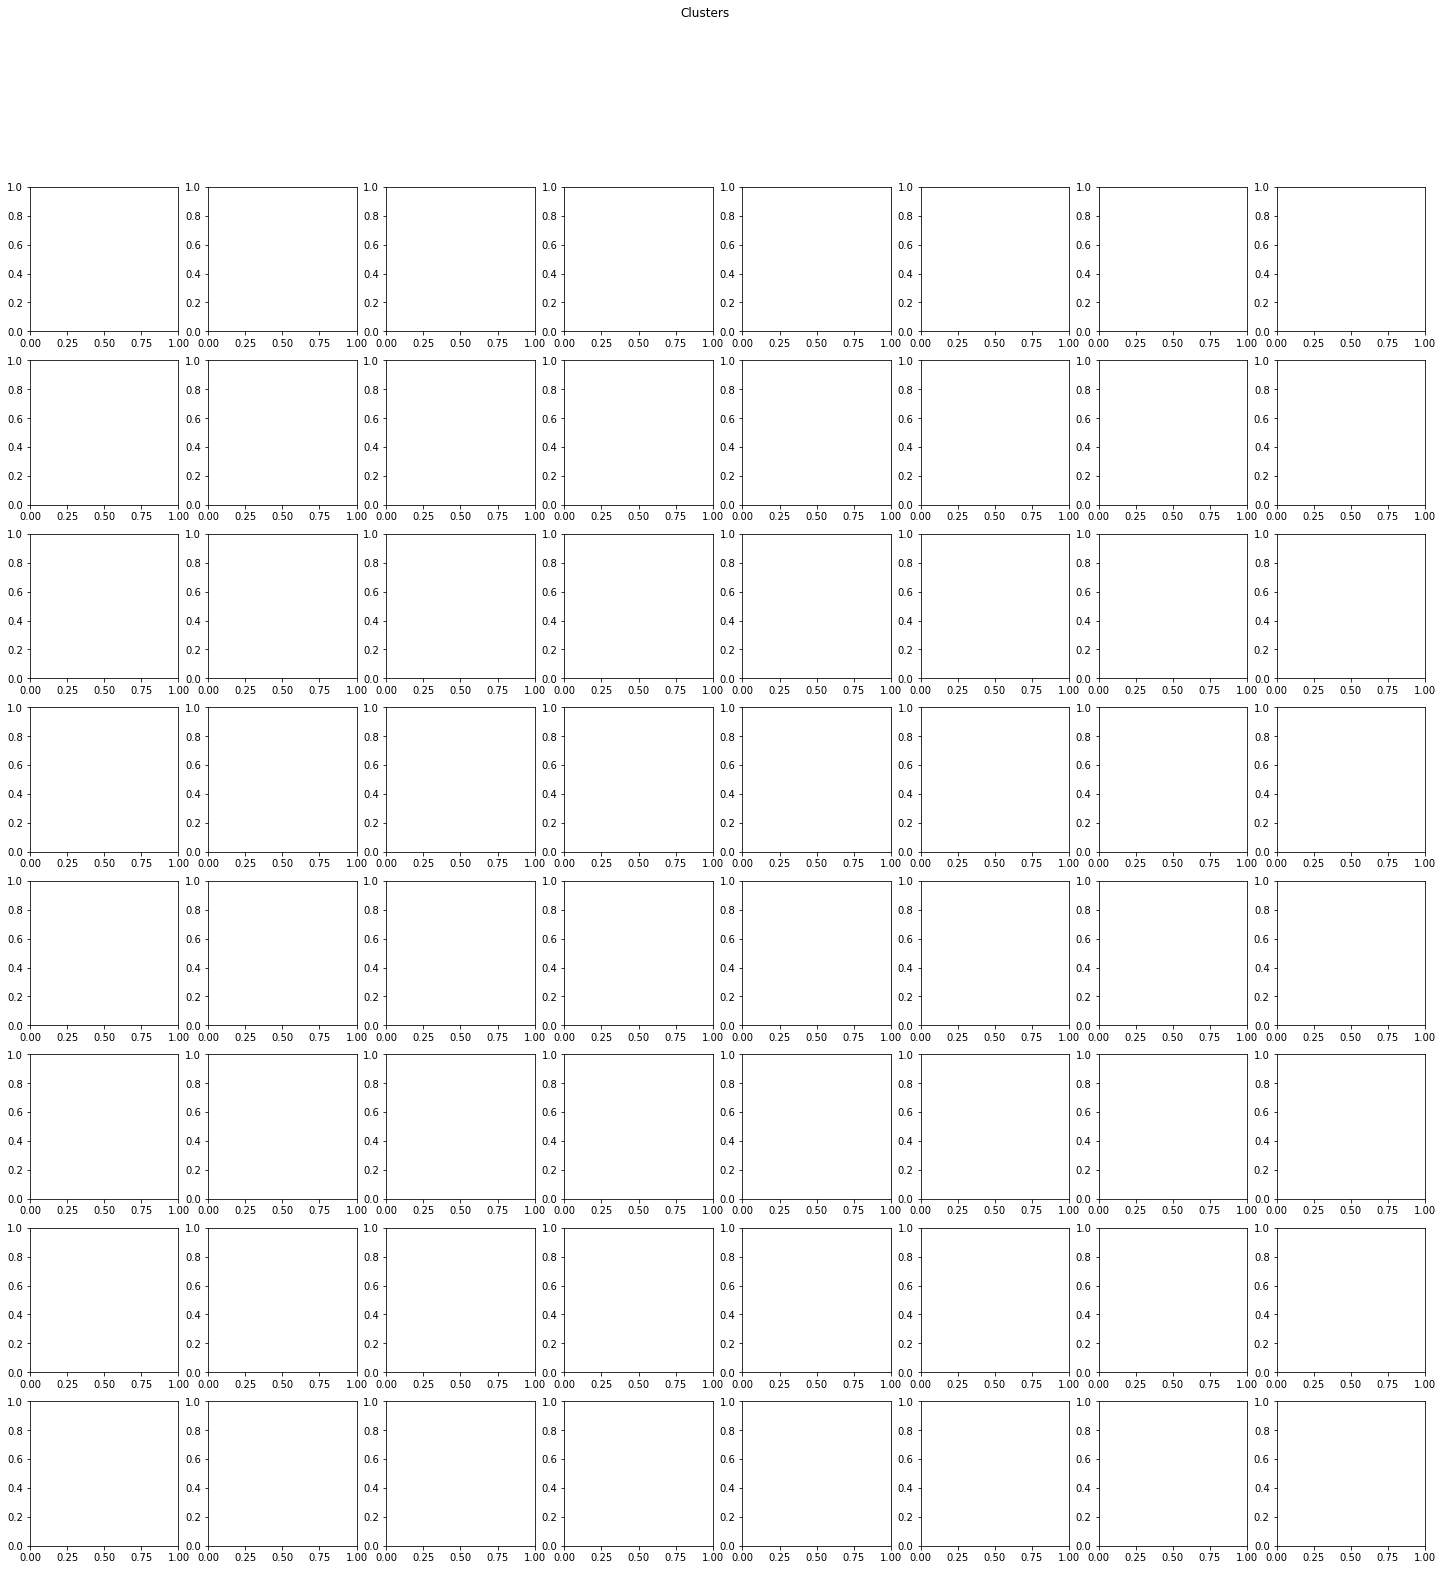

In [42]:
### Plot the results of the clustering ###
# Each plot contains the average of the cluster in red and all the individual
#clusters belonging to the cluster in grey

plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries_scaled[i],c="gray",alpha=0.4)
                cluster.append(mySeries_scaled[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

Because the data is too high dimensional (a datapoint per county per day for almost two years), we will try to reduce dimensions with PCA and apply clustering to the reduced dataset.
We will first apply PCA with a higher number of components, and then check the screeplot to decide on the actual number of components that will be used for the analysis.

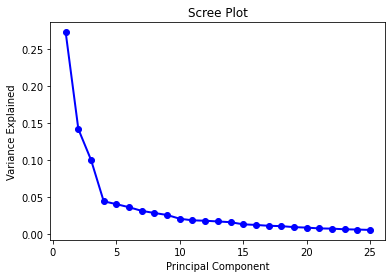

In [53]:
pca25 = PCA(n_components=25)
mySeries_transformed = pca25.fit_transform(mySeries_scaled)


PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

The scree plot shows a clear "elbow", i.e. from the fourth component onwards, extra components don't explain much additional variance. We will reduce the data to 3 principal componenents before clustering again.

In [55]:
pca3 = PCA(n_components=3)
mySeries_transformed = pca3.fit_transform(mySeries_scaled)

Next, we will apply K-Means Clustering. A rule of thumb to decide the number of clusters is to use the square root of the number of data points. In our case, this would yield 56 clusters.

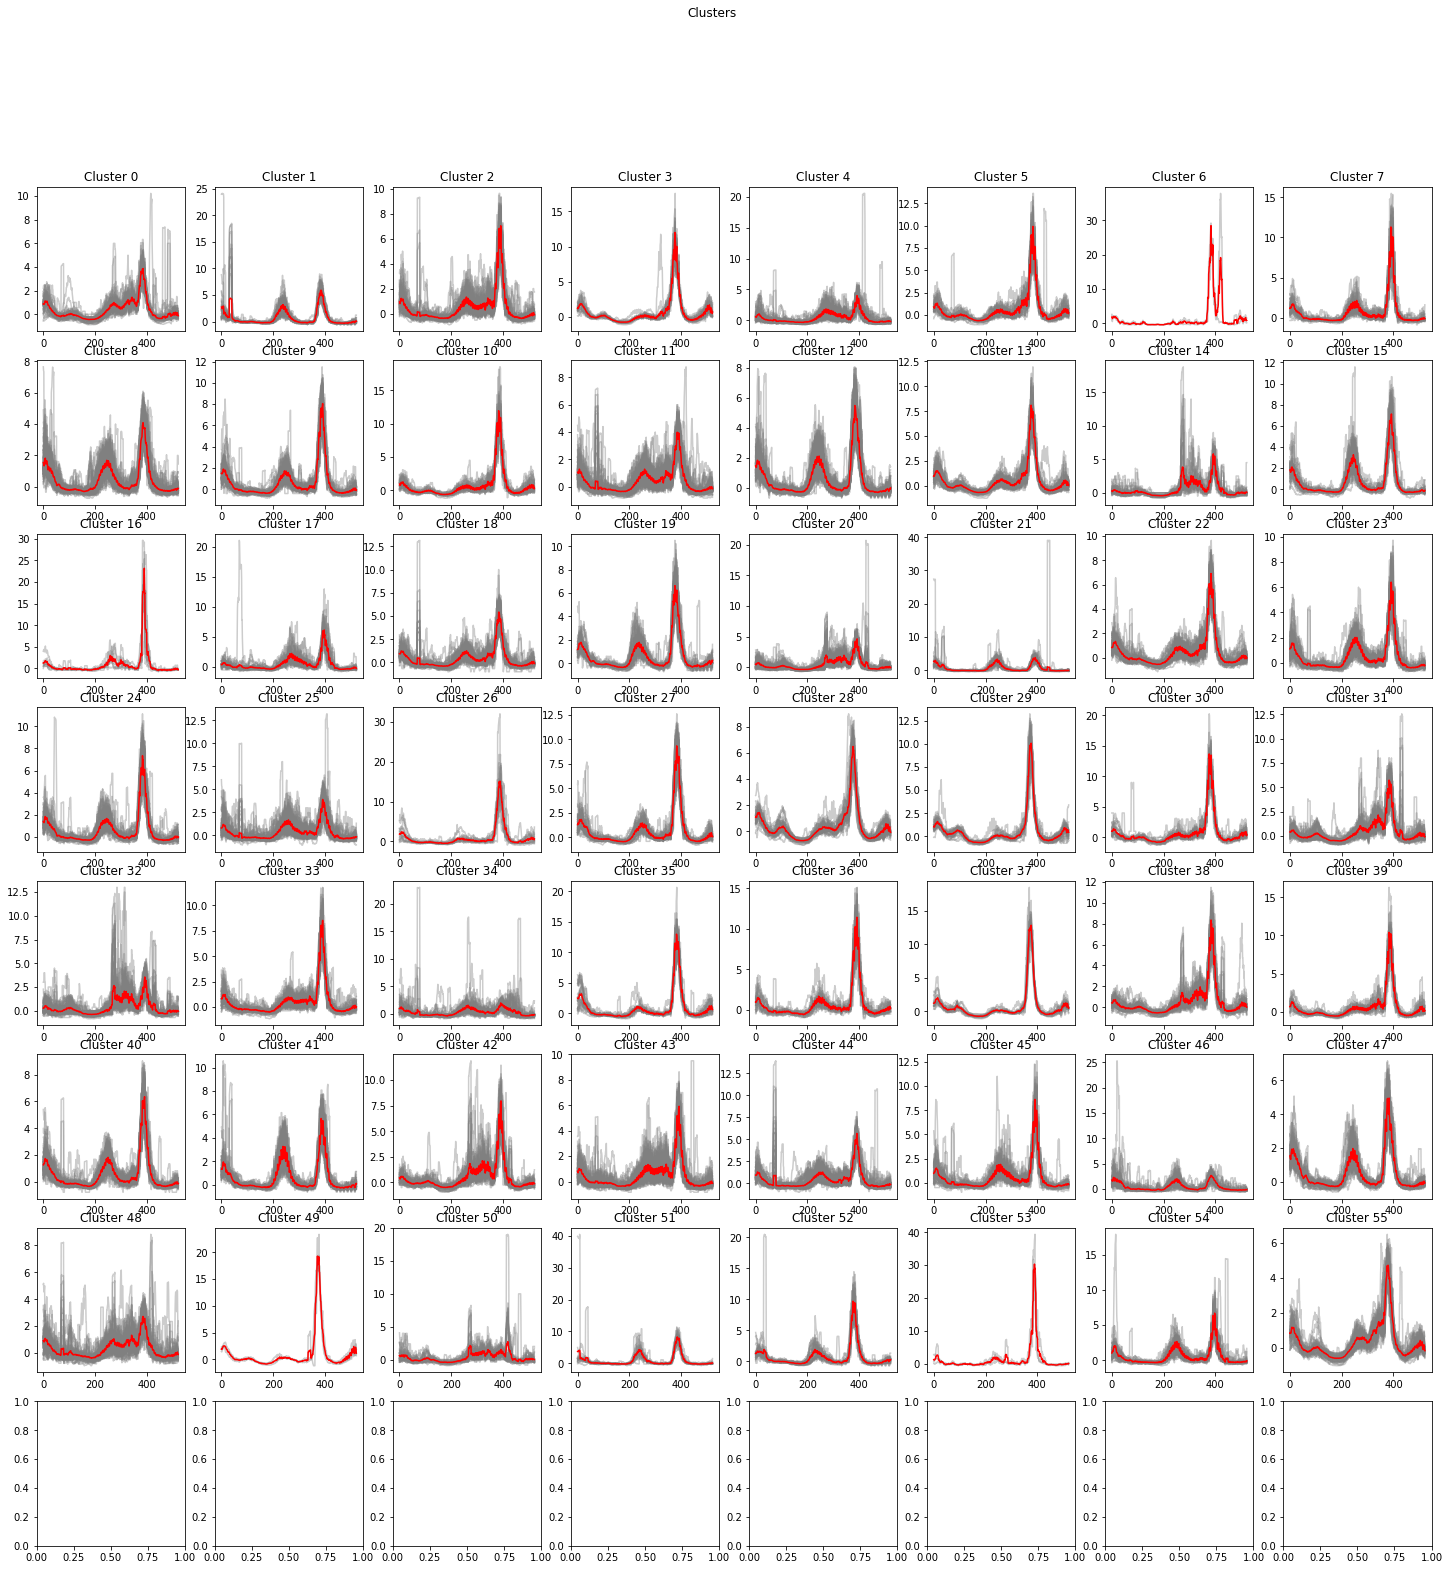

In [65]:
cluster_count = 56
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)
labels = kmeans.fit_predict(mySeries_transformed)

plot_count = math.ceil(math.sqrt(cluster_count))
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries_scaled[i],c="gray",alpha=0.4)
                cluster.append(mySeries_scaled[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

Since 56 is a high number of clusters and several cluster still seem very similar, we will try to reduce the number of clusters. Another method is the elbow method, shown below.

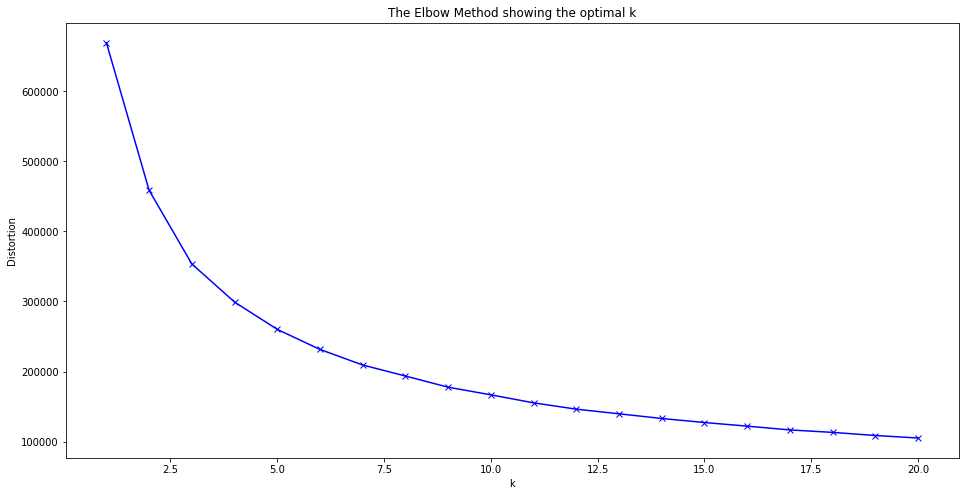

In [57]:
distortions = []
K = range(1,21)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(mySeries_transformed)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Since the plot above does not show a clear elbow, it's unsure what the best number of clusters is. That is why will try out different numbers and plot the results to investigate if a number of clusters makes sense or not. Additionally, we will look at histograms to investigate the distribution of the counties over the different clusters.

### 10 Clusters

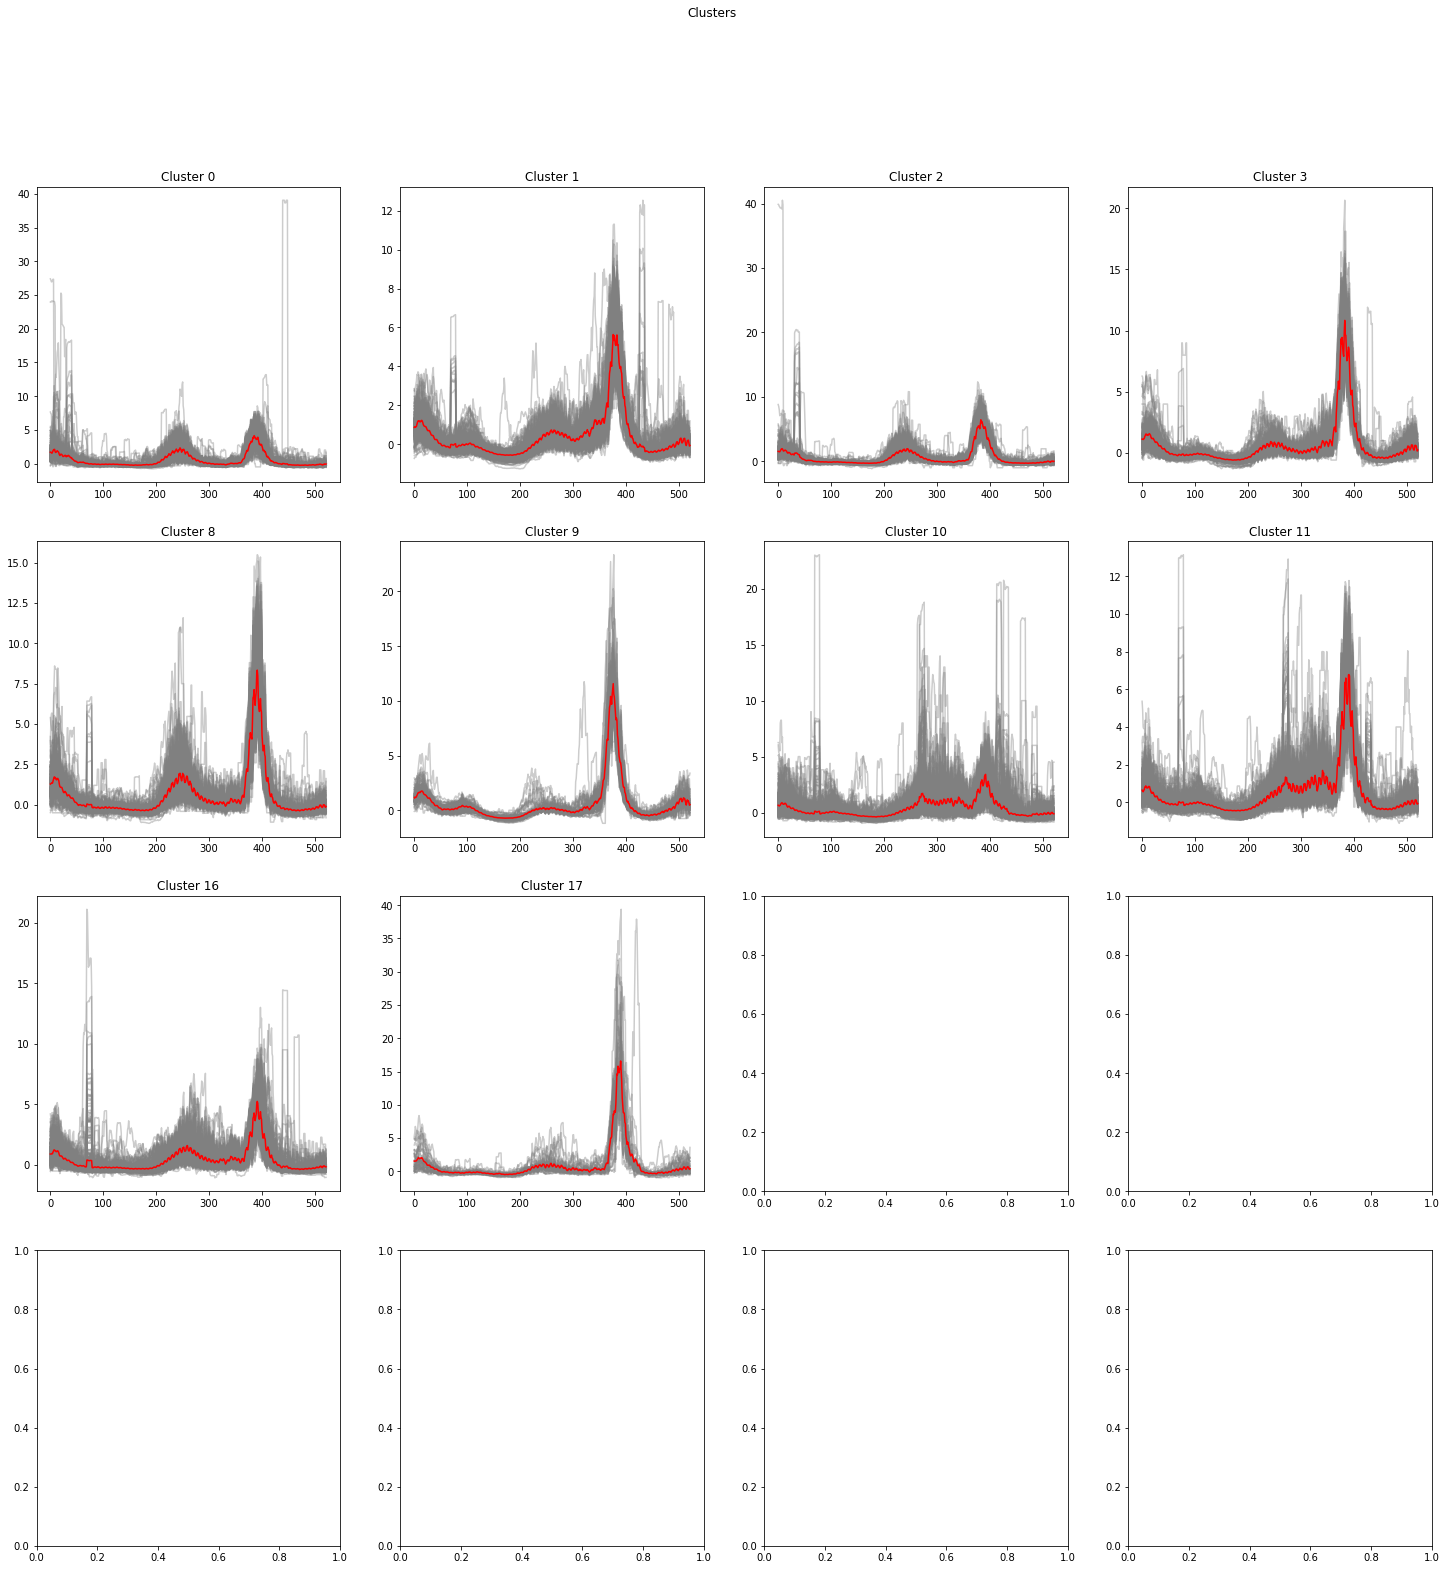

In [66]:
cluster_count = 10
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)
labels = kmeans.fit_predict(mySeries_transformed)

plot_count = math.ceil(math.sqrt(cluster_count))
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries_scaled[i],c="gray",alpha=0.4)
                cluster.append(mySeries_scaled[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

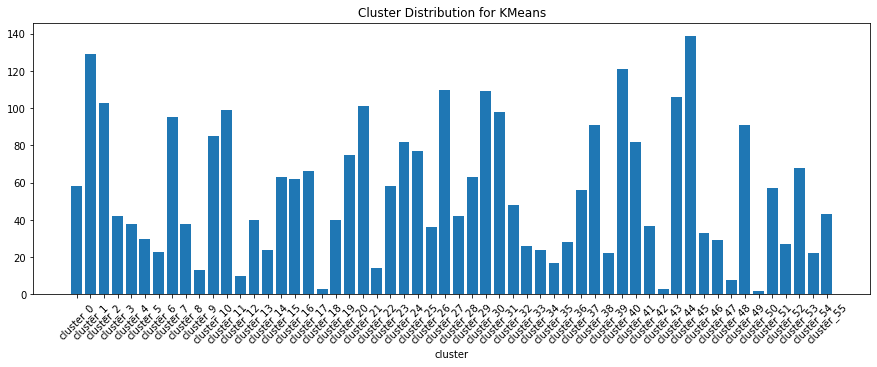

In [59]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.xlabel('cluster')
plt.xticks(rotation=45)

plt.show()

### 5 Clusters

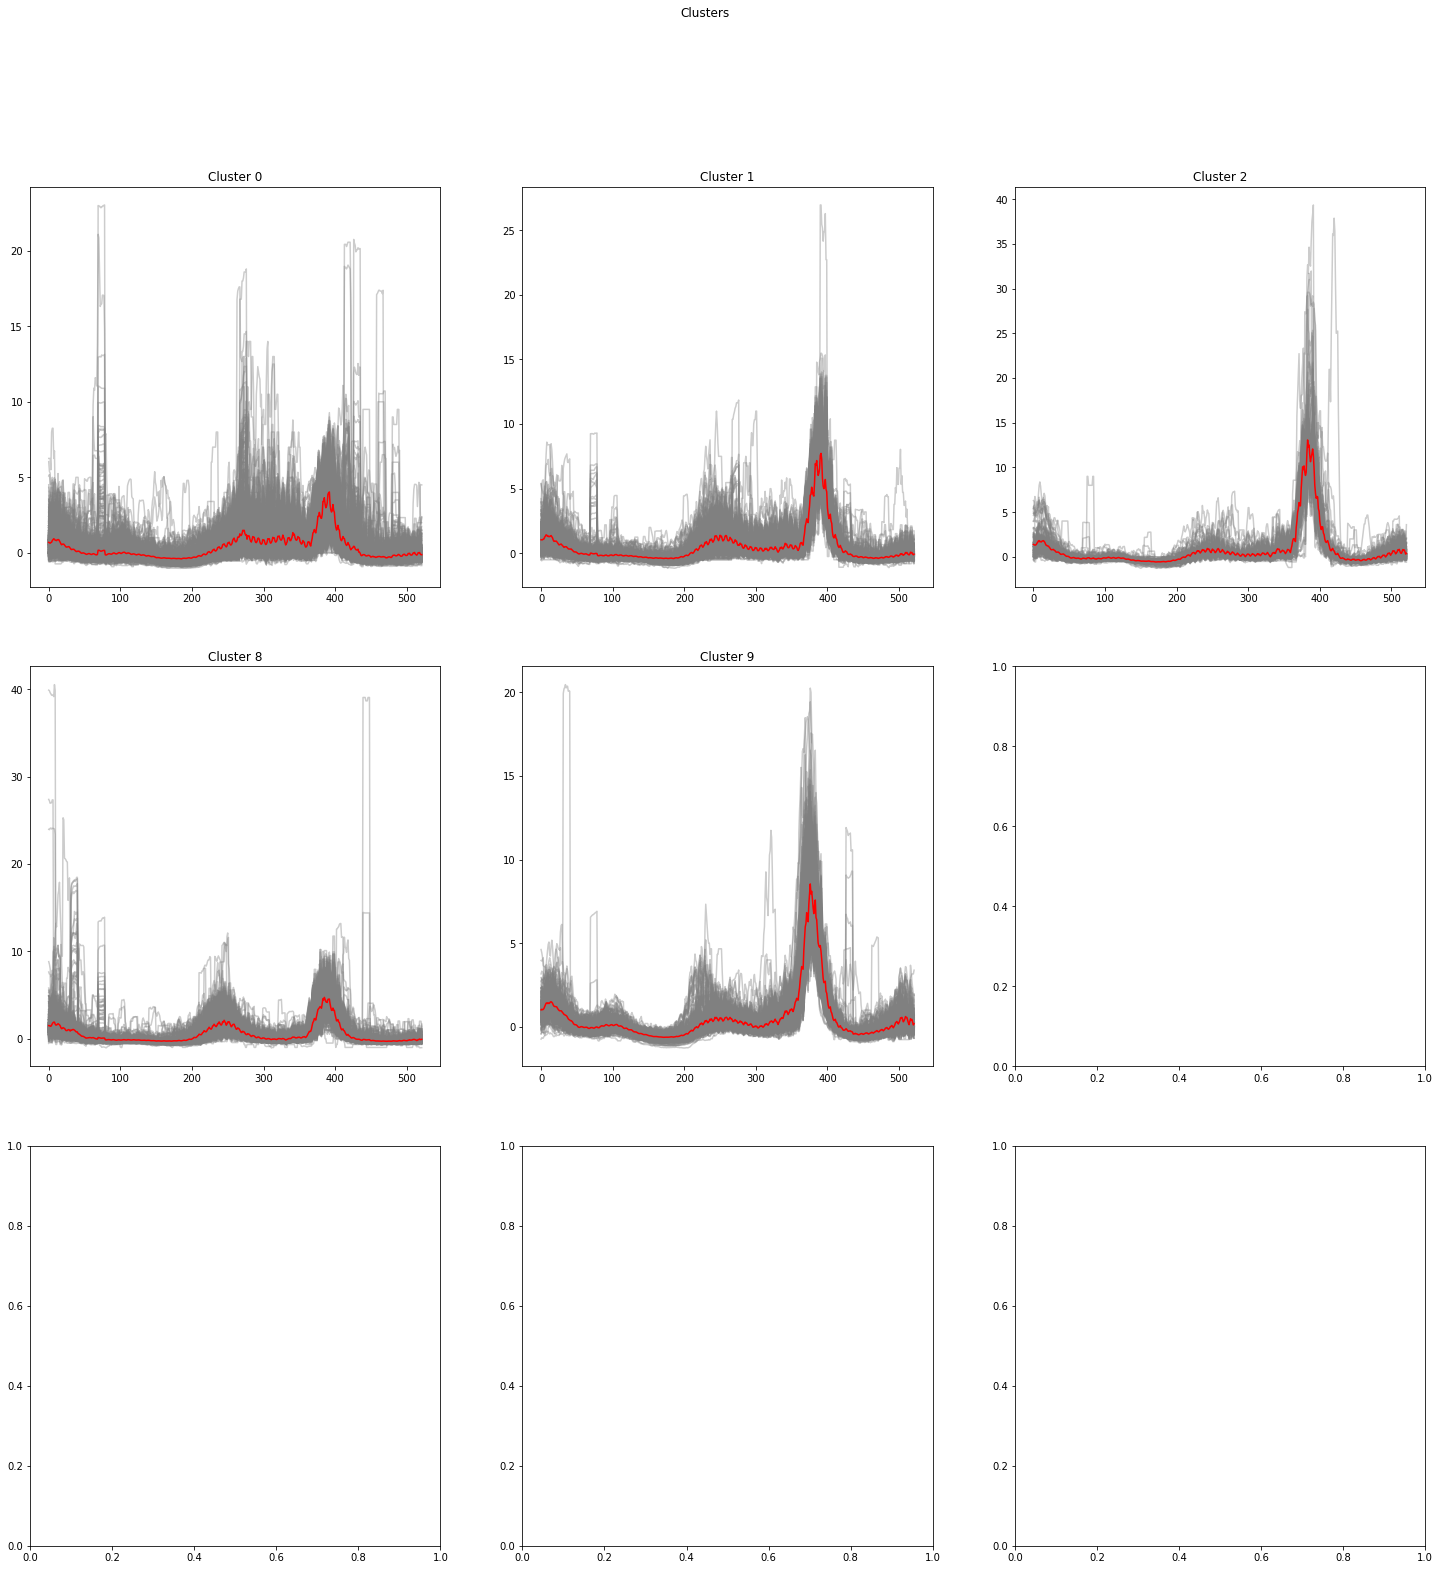

In [67]:
cluster_count = 5
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)
labels = kmeans.fit_predict(mySeries_transformed)

plot_count = math.ceil(math.sqrt(cluster_count))
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries_scaled[i],c="gray",alpha=0.4)
                cluster.append(mySeries_scaled[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

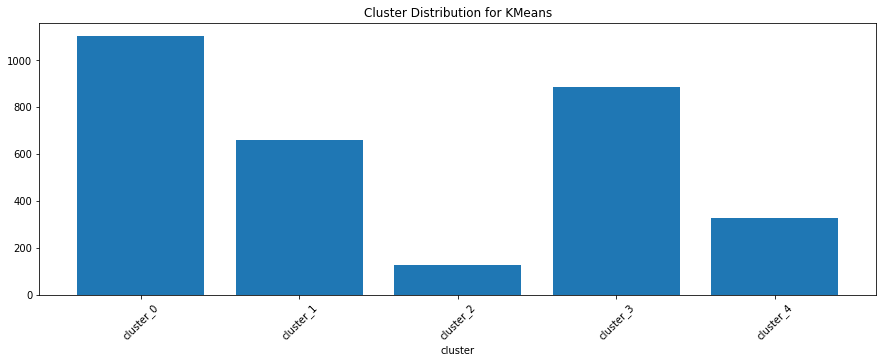

In [68]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.xlabel('cluster')
plt.xticks(rotation=45)

plt.show()

### 2 Clusters

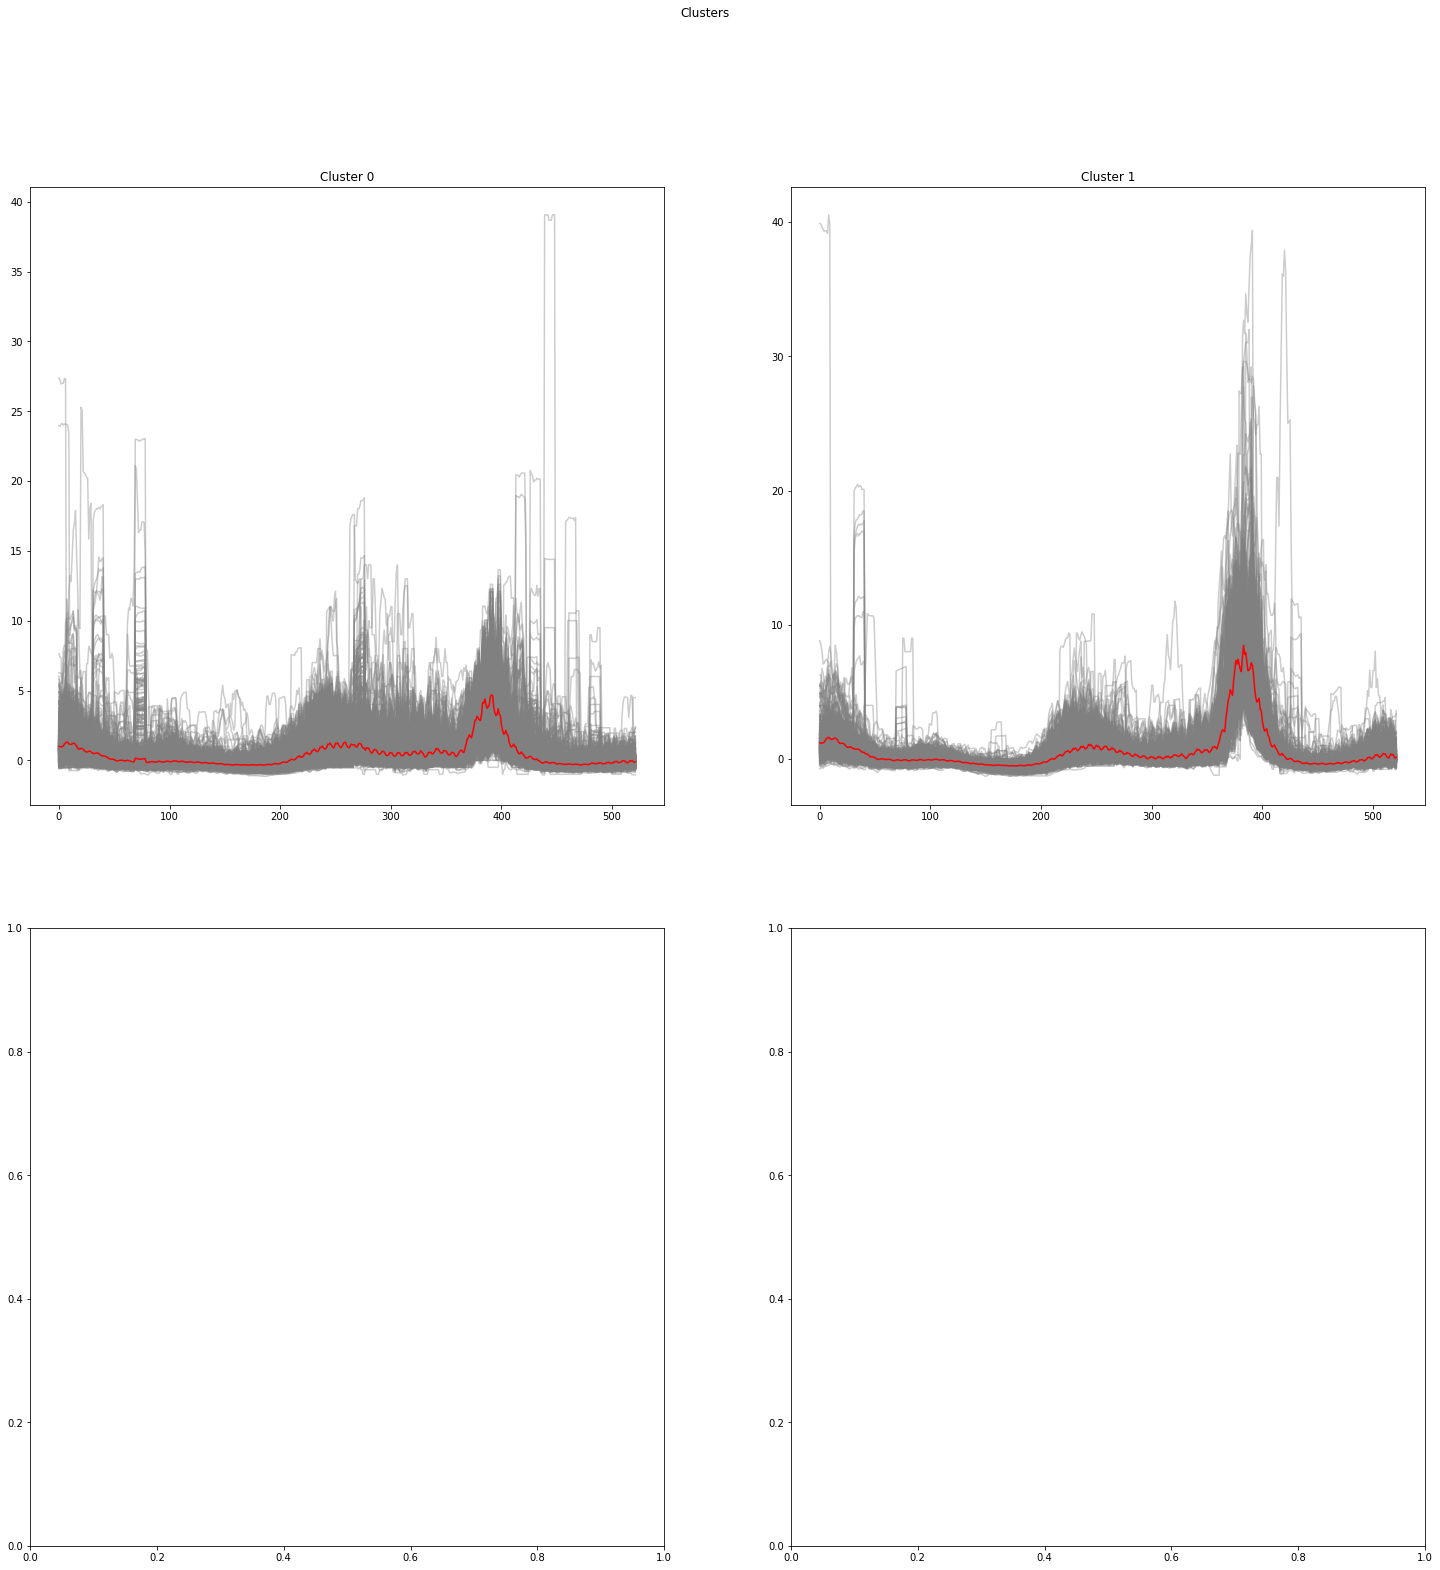

In [69]:
cluster_count = 2
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)
labels = kmeans.fit_predict(mySeries_transformed)

plot_count = math.ceil(math.sqrt(cluster_count))
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries_scaled[i],c="gray",alpha=0.4)
                cluster.append(mySeries_scaled[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

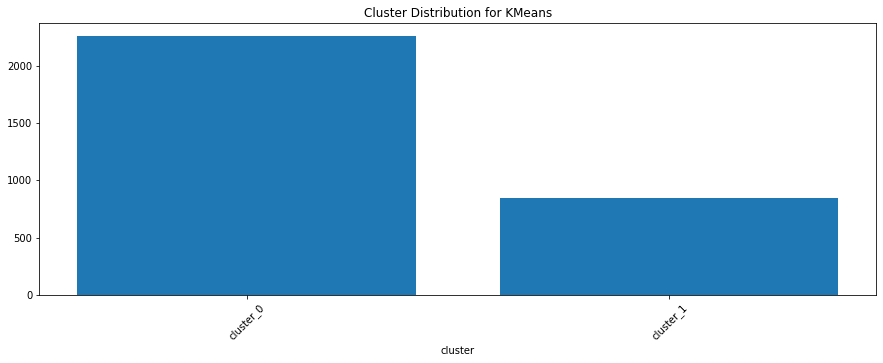

In [70]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.xlabel('cluster')
plt.xticks(rotation=45)

plt.show()

No matter the number of clusters, there always seems to be a peak just before 400 days (which is the beginning of 2022). We will further implement the clusters in the dashboard, so users can visualise the clusters on the map and investigate the influence of clusters on the safest path.